In [1]:
import numpy as np
import keras
import tensorflow as tf
from keras import backend as K 
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt 
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt 
%matplotlib inline

Using TensorFlow backend.


In [2]:
train_path='chest_xray/train'
val_path='chest_xray/val'
test_path='chest_xray/test'

In [3]:
train_batches=ImageDataGenerator().flow_from_directory(train_path,target_size=(224,224), classes=['Normal','Pneumonia'],batch_size=16)
valid_batches=ImageDataGenerator().flow_from_directory(val_path,target_size=(224,224), classes=['Normal','Pneumonia'],batch_size=4)
test_batches=ImageDataGenerator().flow_from_directory(test_path,target_size=(224,224), classes=['Normal','Pneumonia'],batch_size=16)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
vgg19 = keras.applications.vgg19.VGG19()

In [5]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
vgg19.layers.pop()

In [7]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
model = Sequential()
for layers in vgg19.layers:
    model.add(layers)

In [9]:
for layer in model.layers:
    layer.trainable=False

In [10]:
model.add(Dense(2, activation='softmax'))

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [12]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
train = model.fit_generator(train_batches, epochs=5, steps_per_epoch=326, validation_data=valid_batches, validation_steps=16)

Epoch 1/5
326/326 [==============================] - 168s 515ms/step - loss: 0.2119 - accuracy: 0.9114 - val_loss: 0.0777 - val_accuracy: 0.8125
Epoch 2/5
326/326 [==============================] - 179s 548ms/step - loss: 0.1318 - accuracy: 0.9477 - val_loss: 0.2300 - val_accuracy: 0.8125
Epoch 3/5
326/326 [==============================] - 248s 760ms/step - loss: 0.1117 - accuracy: 0.9572 - val_loss: 0.0016 - val_accuracy: 0.9375
Epoch 4/5
326/326 [==============================] - 267s 820ms/step - loss: 0.0992 - accuracy: 0.9615 - val_loss: 0.3559 - val_accuracy: 0.8750
Epoch 5/5
326/326 [==============================] - 268s 821ms/step - loss: 0.0919 - accuracy: 0.9645 - val_loss: 0.0240 - val_accuracy: 0.9375


In [14]:
model.save('VGG19.h5')

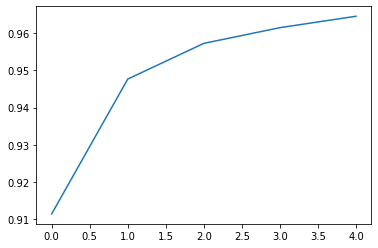

In [15]:
plt.plot(train.history['accuracy'])

In [16]:
def plot_confusion_matrix(cm,classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion amtrix, without normalization')
        
    print(cm)
    
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

In [17]:
predictions = model.predict_generator(test_batches)

Confusion amtrix, without normalization
[[193  41]
 [331  59]]


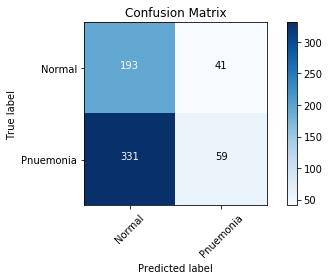

In [18]:
cm = confusion_matrix(test_batches.labels, np.round(predictions[:,0]))
cm_plot_labels=['Normal','Pnuemonia']
plot_confusion_matrix(cm,cm_plot_labels,title='Confusion Matrix')